In [1]:
# %matplotlib notebook

In [2]:
# %matplotlib qt

In [3]:
from __future__ import annotations

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (нужно для 3D)

from maneuvering.types import Scalar
from maneuvering.orbit.keplerian import Kep, KepTrue
from maneuvering.orbit.distance import distance_orbit
from maneuvering.maneuvers.quasi_circular.reference_orbit import trans_devs, reference_orbit
from maneuvering.maneuvers.quasi_circular.transition.coplanar import coplanar_non_intersecting, coplanar_analytical
from maneuvering.maneuvers.quasi_circular.transition.execute import execute, execute_batch
from maneuvering.utils.math_tools import normalize_angle
from maneuvering.maneuvers.maneuver import Maneuver

In [4]:
deg = math.pi / 180.0
mu = 3.9860044158e14

### Задание 2
### Зависимость начальной и конечной ошибок от параметров задачи компланарного перехода

In [5]:
def build_surfaces_for_dw(dw_deg: float, de_vals: np.ndarray, da_vals: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Для фиксированного Δω (градусы) строит поверхности:
      init_err[j,i]  = distance(oi, ot)
      final_err[j,i] = distance(execute(oi, mans, μ), ot)
    где:
      oi = {a0, e0, w0=0, i0=0, Ω0=0},
      ot = {a0 + Δa, e0 + Δe, w=Δω, i=0, Ω=0}.
    Индексы: i — Δe, j — Δa.
    """
    # Базовые (абсолютные) значения
    a0 = 6_800_000.0  # [м]
    e0 = 0.0
    w0 = 0.0
    i0 = 0.0
    raan0 = 0.0

    dw = math.radians(dw_deg)

    init_err = np.zeros((da_vals.size, de_vals.size), dtype=np.float64)
    final_err = np.zeros_like(init_err)

    for j, da in enumerate(da_vals):
        for i, de in enumerate(de_vals):
            oi = Kep(a=a0, e=e0, w=w0, i=i0, raan=raan0)
            ot = Kep(a=a0 + float(da), e=e0 + float(de), w=dw, i=0.0, raan=0.0)

            # Начальная ошибка
            d0 = distance_orbit(oi, ot)

            # Манёвры и исполнение (истинные элементы с ν=0)
            mans = coplanar_analytical(oi, ot, mu)
            of_true = execute(
                oi=KepTrue(a=oi.a, e=oi.e, w=oi.w, i=oi.i, raan=oi.raan, nu=0.0),
                maneuvers=mans,
                mu=mu,
            )
            # Сравниваем геометрию (без ν)
            of_kep = Kep(a=of_true.a, e=of_true.e, w=of_true.w, i=of_true.i, raan=of_true.raan)
            d1 = distance_orbit(of_kep, ot)

            init_err[j, i] = d0
            final_err[j, i] = d1

    return init_err, final_err

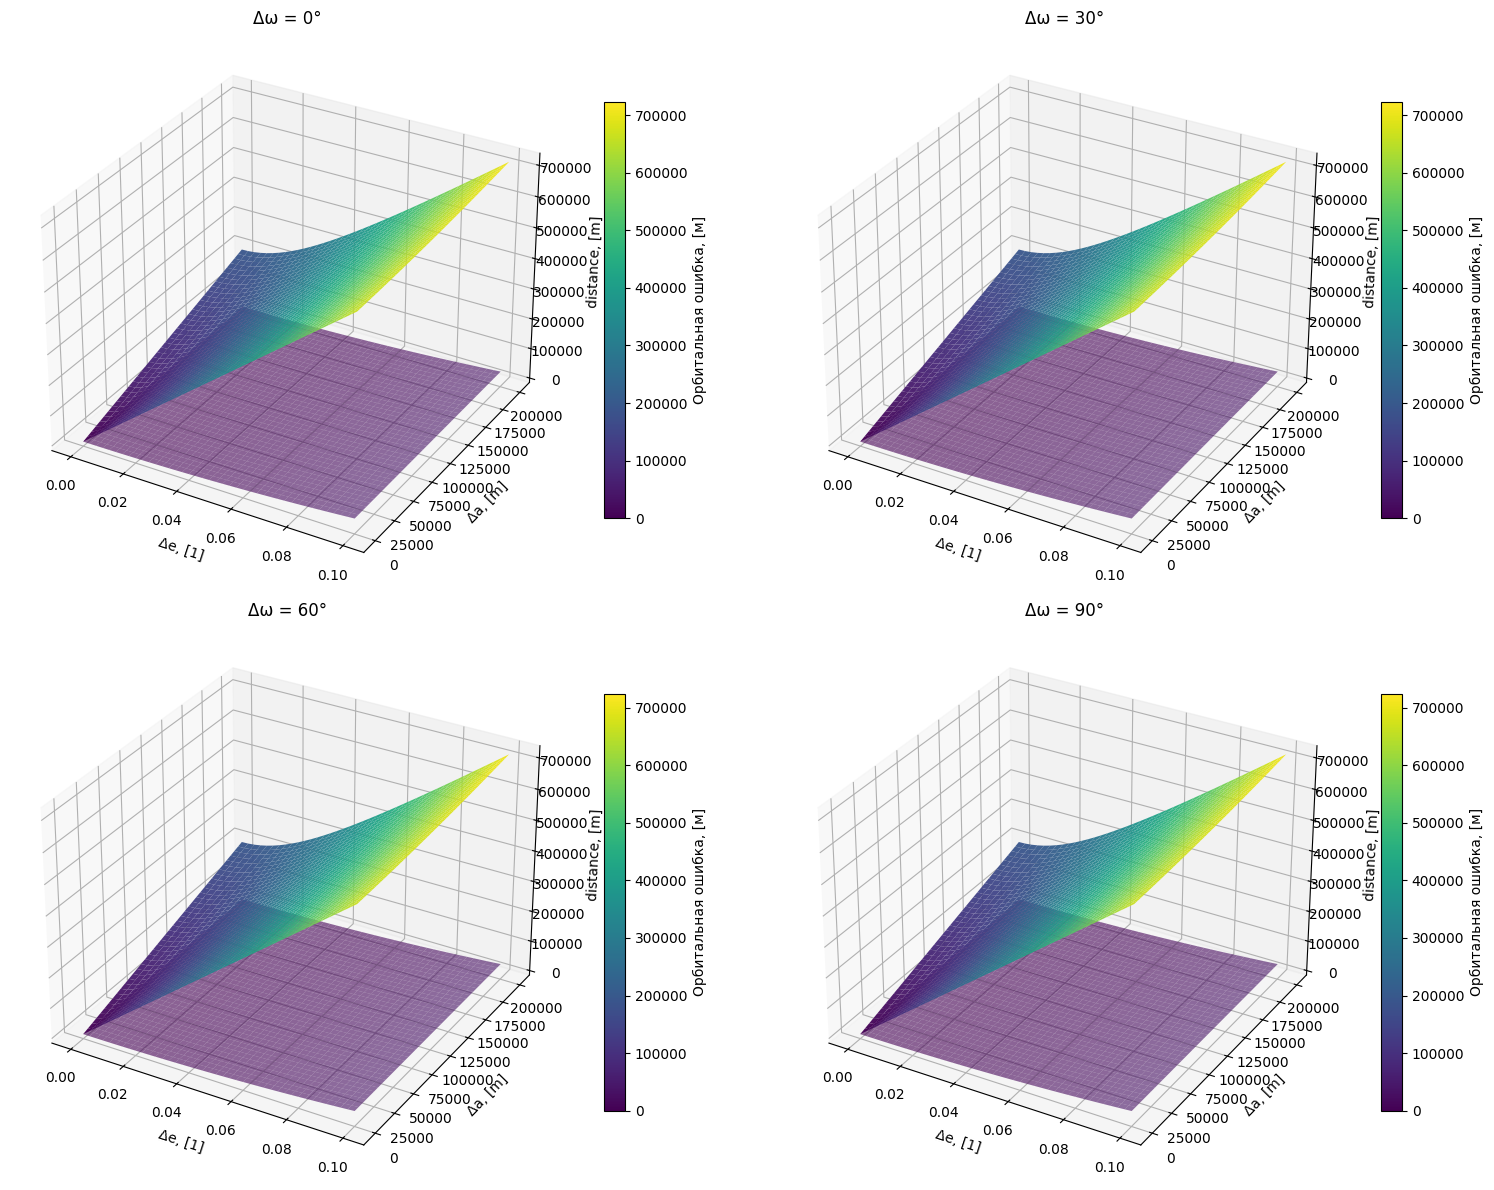

In [6]:
de_vals = np.linspace(0.0, 0.1, 41)  # Δe ∈ [0, 0.1]
da_vals = np.linspace(0.0, 200_000.0, 41)  # Δa ∈ [0, 200 км] (м)
DE, DA = np.meshgrid(de_vals, da_vals)

dws = [0.0, 30.0, 60.0, 90.0]
fig = plt.figure(figsize=(16, 12))

# общая цветовая карта
cmap = cm.viridis

for k, dw in enumerate(dws, start=1):
    init_err, final_err = build_surfaces_for_dw(dw, de_vals, da_vals)

    # Один нормировщик на оба слоя, чтобы цвета были сопоставимы
    z_min = min(init_err.min(), final_err.min())
    z_max = max(init_err.max(), final_err.max())
    norm = Normalize(vmin=z_min, vmax=z_max)

    # Предварительно считаем цвета
    colors0 = cmap(norm(init_err))
    colors1 = cmap(norm(final_err))

    ax = fig.add_subplot(2, 2, k, projection="3d")
    ax.set_title(f"Δω = {int(dw)}°")

    # Две поверхности: начальная (почти непрозрачная), финальная (полупрозрачная)
    surf0 = ax.plot_surface(DE, DA, init_err, rstride=1, cstride=1,
                            facecolors=colors0, linewidth=0, antialiased=True, shade=False, alpha=0.95)
    surf1 = ax.plot_surface(DE, DA, final_err, rstride=1, cstride=1,
                            facecolors=colors1, linewidth=0, antialiased=True, shade=False, alpha=0.6)

    ax.set_xlabel("Δe, [1]")
    ax.set_ylabel("Δa, [m]")
    ax.set_zlabel("distance, [m]", labelpad=6)

    # Добавим colorbar, привязав к нормировщику
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array([])  # заглушка для colorbar
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.75, pad=0.05)
    cbar.set_label("Орбитальная ошибка, [м]")

fig.tight_layout()
plt.show()

### Задание 3
### Зависимости орбитальных элементов от абсолютного угла, пройденного КА, с активным маневрированием

In [7]:
def plot_transition_series(oi, ot, mu):
    """
    1) Считает манёвры: mans = coplanar_analytical(oi, ot, mu)
    2) Прогоняет: states, angles_abs = execute_batch(oi, mans, step, mu)
       (step фиксируем внутри как 2π/720)
    3) Строит 6 графиков (2×3): a, e, ω; i, Ω, ν.
       Ось X — накопленный абсолютный угол u=ω+ν (радианы).
    Возвращает: fig, axes, states, angles_abs
    """
    # 1) Манёвры
    mans = coplanar_analytical(oi, ot, mu)

    # 2) Прогон (фиксированный шаг по u)
    states, angles_abs = execute_batch(oi, mans, mu)

    if not states:
        raise ValueError("Пустой список состояний.")

    # 3) Достаём ряды
    a = np.array([s.a for s in states], dtype=float)
    e = np.array([s.e for s in states], dtype=float)
    w = np.array([s.w for s in states], dtype=float)
    inc = np.array([s.i for s in states], dtype=float)
    Om = np.array([s.raan for s in states], dtype=float)
    nu = np.array([s.nu for s in states], dtype=float)
    x = np.asarray(angles_abs, dtype=float)  # уже в радианах

    # Разворачиваем углы (чтобы не было скачков через 2π)
    unwrap = lambda arr: np.unwrap(arr, discont=np.pi)
    w_u, i_u, Om_u, nu_u = map(unwrap, (w, inc, Om, nu))

    # Оформление
    plt.rcParams.update({
        "figure.constrained_layout.use": True,
        "axes.grid": True,
        "font.size": 11,
        "figure.figsize": (12, 6),
    })

    fig, axes = plt.subplots(2, 3, sharex=True)
    (ax_a, ax_e, ax_w), (ax_i, ax_Om, ax_nu) = axes

    # Верхний ряд
    ax_a.plot(x, a, lw=2)
    ax_a.set_title("Большая полуось a, [м]")

    ax_e.plot(x, e, lw=2)
    ax_e.set_title("Эксцентриситет e, [1]")

    ax_w.plot(x, w_u, lw=2)
    ax_w.set_title("Аргумент перицентра ω, [рад]")

    # Нижний ряд
    ax_i.plot(x, i_u, lw=2)
    ax_i.set_title("Наклонение i, [рад]")

    ax_Om.plot(x, Om_u, lw=2)
    ax_Om.set_title("Долгота восходящего узла Ω, [рад]")

    ax_nu.plot(x, nu_u, lw=2)
    ax_nu.set_title("Истинная аномалия ν, [рад]")

    # Общая ось X
    axes[1, 1].set_xlabel("Накопленный угол u = ω + ν, [рад]")

    for ax in axes.ravel():
        ax.tick_params(axis='both', which='major', labelsize=10)

    plt.show()

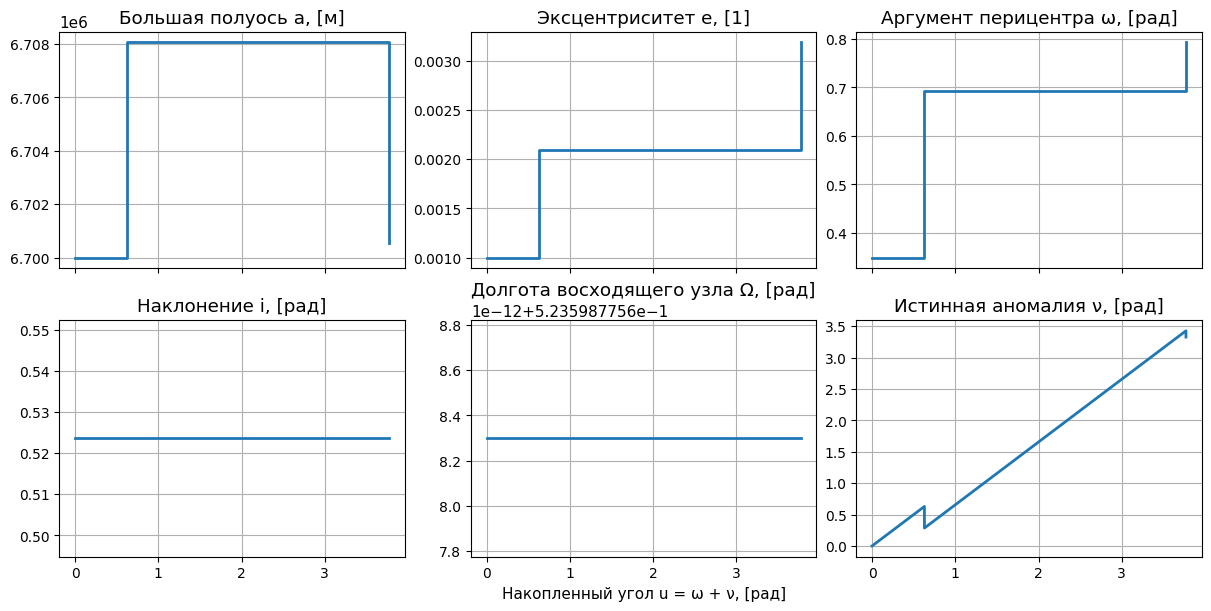

In [8]:
# 1) Пересекающиеся
oi_int = KepTrue(a=6_700_000.0, e=0.00100, w=20.0 * deg, i=30.0 * deg, raan=30.0 * deg, nu=0.0)
ot_int = Kep(a=6_700_500.0, e=0.00300, w=60.0 * deg, i=30.0 * deg, raan=30.0 * deg)
plot_transition_series(oi_int, ot_int, mu)

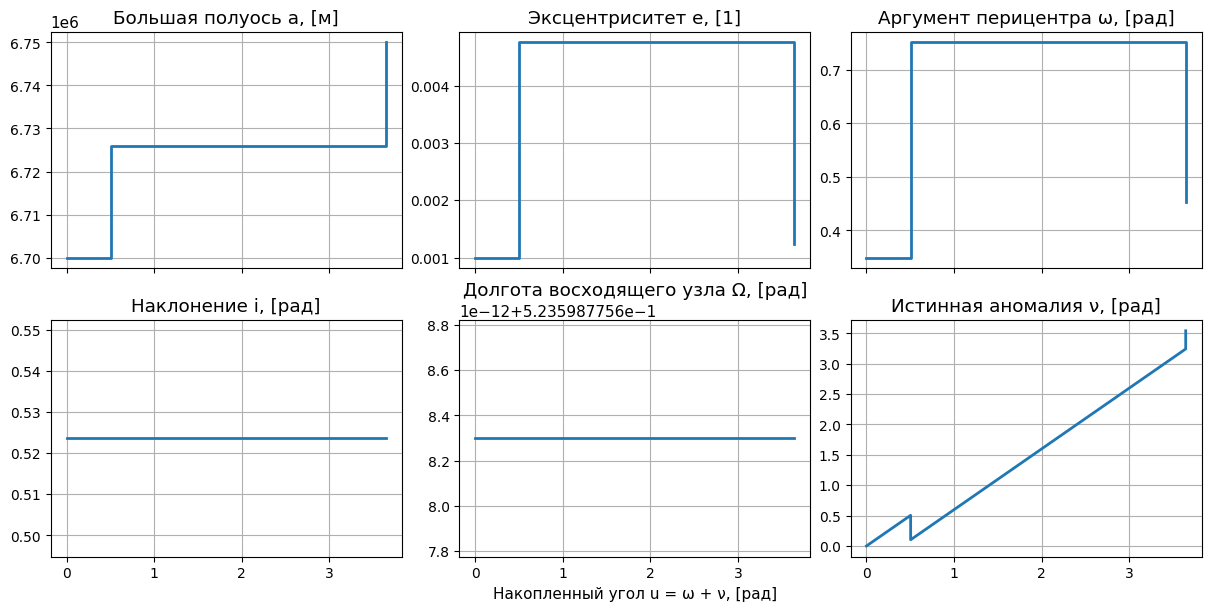

In [9]:
# 2) Непересекающиеся
oi_non = KepTrue(a=6_700_000.0, e=0.00100, w=20.0 * deg, i=30.0 * deg, raan=30.0 * deg, nu=0.0)
ot_non = Kep(a=6_750_000.0, e=0.00120, w=30.0 * deg, i=30.0 * deg, raan=30.0 * deg)
plot_transition_series(oi_non, ot_non, mu)

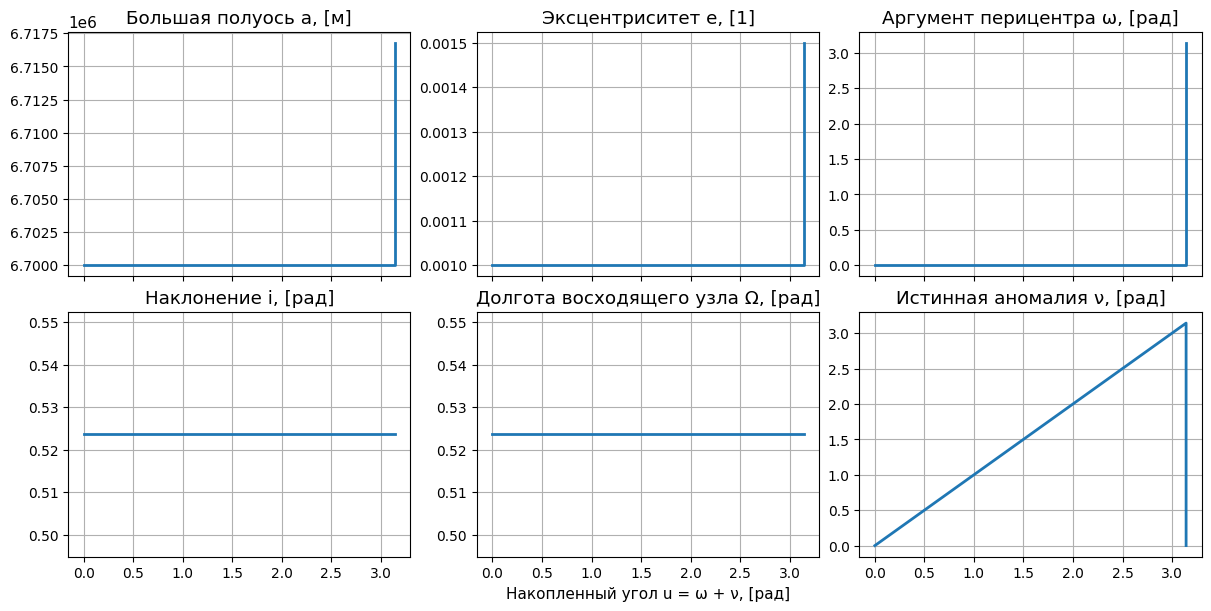

In [10]:
# 3) Касающиеся (граница)
oi_tan = KepTrue(a=6_700_000.0, e=0.00100, w=0.0 * deg, i=30.0 * deg, raan=30.0 * deg, nu=0.0)
ot_tan = Kep(a=6_716_770.963704631, e=0.00150, w=180.0 * deg, i=30.0 * deg, raan=30.0 * deg)
plot_transition_series(oi_tan, ot_tan, mu)